# 量子ウォークによる探索アルゴリズム

量子ウォークは古典のマルコフ連鎖の量子版であり、多くの量子アルゴリズムにとって重要なものです。この章ではグラフ上にマークした要素を見つける量子ウォークによる探索アルゴリズムを実装します。このアルゴリズムは古典に比べて二次加速を持ちます。
## 目次
1. [古典マルコフ連鎖](#markov)
2. [量子ウォーク](#qwalks)
    1. [コイン量子ウォーク](#coined)
    2. [セゲディ量子ウォーク](#szegedy)
    3. [コインとセゲディ量子ウォークの等価性](#equivalence)
3. [例: 超立方体上の量子ウォーク](#example1)
4. [量子ウォークによる探索アルゴリズム](#qwalkalgo)
5. [例: 4次元超立方体上の量子ウォークによる探索](#qiskiti)
6. [リファレンス](#references)

## 1. 古典マルコフ連鎖 <a name="markov"></a>
マルコフ連鎖は現実のプロセスをモデル化するためによく使われる確率過程です。状態と遷移確率からなり、各時間ステップでの状態間の確率の移動を記述します。ここで紹介する離散時間マルコフ連鎖では、時間ステップは離散的です。マルコフ連鎖はマルコフ性を満たします、つまり次のステップでの確率過程は現在のステップのみに依存して、それ以前には依存しません。マルコフ連鎖は状態間の確率の移動を表現する遷移行列 P を持ちます。ここで、マルコフ連鎖の例と、その遷移行列 $P$ を示します。
\begin{equation}
P=
\begin{pmatrix}
0.1 & 0.3 & 0.3\\
0.1 & 0.1 & 0.2 \\
0.8 & 0.6 & 0.5
\end{pmatrix}
\label{eq:matrix_example}
\end{equation}
<img src="images/markov_example.png" width='480'>

遷移行列 $P$ が与えられると、$t$ 時間ステップ後の確率分布を $P^t$ により計算できます。

## 2. 量子ウォーク <a name="qwalks"></a>
量子ウォークは古典のマルコフ連鎖の量子版です。測定するまでは、量子ウォークは全ての可能な経路の重ね合わせを取ります。また、量子干渉によりある状態は打ち消しあいます。この現象を、間違えた答えを消去するような設計に利用することで、量子ウォークアルゴリズムをランダムウォークよりも速くします。コイン量子ウォークとセゲディ量子ウォークがよく用いられ、これらはある条件下では等価になります。コイン量子ウォークはグラフ上の頂点を、セゲディ量子ウォークは辺を動きます。量子ウォークの実装の前にこの二つのモデルを紹介します。

 $\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
 $\newcommand{\bra}[1]{\left\langle{#1}\right|}$
### 2.1 コイン量子ウォーク <a name="coined"></a>
　コイン量子ウォークの簡単な例は、無限長の整数上の運動です。この場合、整数 $\mathbb{Z}$ 上での位置を $\{\ket{j} : j \in  \mathbb{Z} \}$ とします。そして、コインの計算基底は $\{\ket{0}, \ket{1}\}$ とし、コインが $\ket{0}$ の場合はある方向に動き、コインが $\ket{1}$ の場合はもう一方に動きます。

コイン量子ウォークはグラフの頂点上を動くので、頂点を状態とします。辺で繋がっている状態間のみ動くことができます。コインモデルでは、二つの量子状態空間と二つの演算子を使います。一つ目の状態空間は位置を表す位置状態です。上記の運動では、整数上のどこでも移動できるので、整数となります。もう一方は、コイン状態です。コイン状態は次のステップでどのように動くかを決定します。このコイン状態と位置状態とを合わせて、ヒルベルト空間上のベクトルとして表現できます。コイン状態を $\mathcal{H}_C$ のベクトルとして表し、位置状態を $\mathcal{H}_P$ のベクトルとして表すと、運動のすべての量子状態空間は $\mathcal{H} = \mathcal{H}_C \otimes \mathcal{H}_P$ となります。

すでに述べたように、モデルには二つの演算子がありコイン演算子 $C$ とシフト演算子 $S$ です。コイン演算子は時間ステップ毎に $\mathcal{H}_C$ に作用して重ね合わせ状態を作るため、全ての可能な経路を同時に動きます。整数上の運動では、時間ステップ毎に左と右の両方に動くことになります。いろいろなコイン演算子がありますが、よく用いられるのはアダマールコインとグローバーコインです。アダマールコインはアダマールゲートにより等確率での重ね合わせ状態を作ります: 

\begin{equation}
    H = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1 
\end{bmatrix}
\end{equation}

グローバーコインはグローバーのアルゴリズムにあるグローバーの拡散演算子を用い、以下のように定義します

\begin{equation}
    G = 
    \begin{bmatrix}
\frac{2}{n} -1 & \frac{2}{n} & \ldots & \frac{2}{n}\\
\frac{2}{n} & \frac{2}{n} - 1  & \ldots & \frac{2}{n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{2}{n} & \frac{2}{n} & \ldots & \frac{2}{n} -1
\end{bmatrix}
\end{equation}

アダマールコインのようにグローバーコインも重ね合わせ状態を作ります。しかし、振る舞いは少し異なります。位置 $\ket{000}$ にグローバーコインを作用させると、下図のような状態ベクトルの確率分布を得ます。このように、アダマールコインのような等確率の重ね合わせ状態を作りません。他の状態に比べて、$\ket{000}$ により大きな確率を持ちます。

<img src="images/grover_prob.svg" width='480'>

モデルのもう一つの演算子のシフト演算子は $\mathcal{H}_P$ に作用して、次の位置に移動させます。整数上の運動では、シフト演算子により、コインが $\ket{0}$ の時は左に動き、コインが $\ket{1}$ の時は右に動きます: 

\begin{equation}
    S \ket{0}\ket{j} = \ket{0}\ket{j+1}
\end{equation}

\begin{equation}
    S \ket{1}\ket{j} = \ket{1}\ket{j-1}
\end{equation}


上記で定義されたシフト演算子で、一ステップ分のコイン量子ウォークを以下のユニタリ演算子として表現できます
\begin{equation}
    U = SC,
\end{equation}

ここで C はコイン演算子です。整数上の量子ウォークでアダマールコインを用いましたが、C はアダマールコインでも、グローバーコインでも、その他のコイン演算子でも用いることができます。


先に進みましょう。$t$ 時間ステップ後の量子状態 $\ket{\psi}$ は以下で表すことができます
\begin{equation}
    \ket{\psi (t)} = U^t \ket{\psi(0)},
\end{equation}
ここで、$\ket{\psi(0)}$ は初期状態で、U は一ステップ分の演算子です[1]。

コイン量子ウォークは多くの正則グラフ(全ての頂点で隣接する頂点の数が同じグラフ)で安定しています[2]。 もう一つのモデルであるセゲディ量子ウォークは非正則グラフに適しており、次の章で解説します。

### 2.2 セゲディ量子ウォーク <a name="szegedy"></a>
コイン量子ウォークはグラフの頂点を動きましたが、セゲディ量子ウォークは元のグラフの二部二重被覆グラフ上の辺を動きます。二重被覆グラフとは元のグラフの二倍の頂点を持つグラフです。二部二重被覆グラフの二つの頂点は、元のグラフでその頂点が繋がっている場合にのみ、辺で繋がります。このモデルを作るには、古典のランダムウォークの遷移確率行列 P から始めます。1 章で示したように、古典の離散時間ランダムウォークは遷移行列 P で記述されます。任意の $N \times N$ の遷移行列 $P$ を持つ $N$-頂点グラフに対して、離散時間量子ウォークをヒルベルト空間 $\mathcal{H}^N \otimes \mathcal{H}^N$ 上のユニタリ演算子として定義できます。$P_{jk}$ を $j$ から $k$ へ遷移する確率と定義しましょう。運動を定義する前に、正規化された状態を定義します

\begin{equation}
    \ket{\psi_j} := \sum_{k=1}^N \sqrt{P_{kj}} \ket{j,k}, \; j=1,...,N
\end{equation}

そして、${\ket{\psi_j}}:j=1,...,N$ への射影は

\begin{equation}
    \Pi := \sum_{j=1}^N \ket{\psi_j} \bra{\psi_j}
\label{eq:sz_pi}
\end{equation}

シフト演算子を導入します:

\begin{equation}
    S := \sum_{j,k=1}^N \ket{j,k} \bra{k,j}
\label{eq:sz_s}
\end{equation}

上で定義した $S$ と $\Pi$ を用いて一ステップ分の離散時間量子ウォークを定義します:

\begin{equation}
    U := S(2 \Pi - 1),
\label{eq:sz_op}
\end{equation}

ここで、$(2 \Pi - 1)$ は反射演算子です。また、$t$ ステップ後の状態は $U^t$ により定義できます[2]。

### 2.3 コインとセゲディ量子ウォークの等価性 <a name="equivalence"></a>
グローバーコインによるコイン量子ウォークはセゲディ量子ウォークと等価であることが知られています。詳細は Thomas G. Wong による文献[3]を参照ください、文献では演算子の等価性についても示されています。


## 3. 例: 超立方体上の量子ウォーク <a name="example1"></a>
超立方体は $3$次元の立方体を $n$次元化したものです。全ての頂点の次数は $n$ で、超立方体は $N=2^n$個の頂点を持ちます。二値の $n$タプルを用いて超立方体の頂点を表現できます。隣接する頂点の二値表現は一つの二値のみが異なります。例えば4次元超立方体の場合、頂点 $0000$ の隣接頂点は $0001$, $0010$, $0100$, $1000$ です。したがって、ハミング距離が1の全ての頂点と接続しています。辺も同時にラベルできます。二つの隣接する頂点のa番目のビットが異なる場合、$a$とラベルされた辺で繋がります。

超立方体のコイン量子ウォークを表現するヒルベルト空間は $\mathcal{H} = \mathcal{H}^n \otimes \mathcal{H}^{2^n}$ です、ここで、$\mathcal{H}^n$ はコイン空間で、$\mathcal{H}^{2^n}$ は位置です。計算基底では

\begin{equation}
    \big\{ \ket{a,\vec{v}}, 0 \leq a \leq n-1, \vec{v} \in  \{(00...00), (00...01), ....., (11...11 )\} \big\}. 
\end{equation}

辺 $a$ を表すコイン計算基底 $a$ は、移動の方向を表します。$a=0$ の場合、現在の辺とは一番目の二値が異なる辺へ移動します。また、$a=1$ の場合、現在の辺とは二番目の二値が異なる辺へ移動します。$\vec{e}_a$ を $a$ 以外は全て $0$ をとる二値の n タプルとします。そして、シフト演算子 $S$ は 状態 $\ket{a} \ket{\vec{v}}$ を $\ket{a} \ket{\vec{v} \oplus \vec{e}_a}$ へ移動します。

\begin{equation}
    S \ket{a} \ket{\vec{v}} = \ket{a} \ket{\vec{v} \oplus \vec{e}_a}.
\end{equation}

ここでは、グローバーコイン $G$ を用います。そして発展演算子は

\begin{equation}
    U = SG.
\end{equation}

次に、4次元超立方体の量子ウォークをどのように実装するのかを紹介します。コイン演算子とシフト演算子の実装が必要となります。Qiskitから必要なライブラリをインポートするところから始めます。

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

回路は位置に4個、コインに2個用いて、6量子ビットからなります。前に述べたようにコインはグローバーコインで、グローバーのアルゴリズムの拡散演算子です。この実装からはじめます。

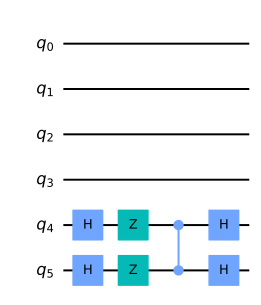

In [3]:
one_step_circuit = QuantumCircuit(6, name=' ONE STEP') 
# Coin operator
one_step_circuit.h([4,5])
one_step_circuit.z([4,5])
one_step_circuit.cz(4,5)
one_step_circuit.h([4,5])
one_step_circuit.draw() 

次にシフト演算子を実装します。隣接する頂点にだけ移動します、また、全ての隣接する頂点は一ビットだけ異なります。コインに従って移動するため、頂点の量子ビットの一つに対してNOTゲートを作用します。コインが $\ket{11}$ 状態の時は、一番目の頂点の量子ビットが異なる状態に移動します。コインが $\ket{10}$ または $\ket{01}$ 状態の時は、それぞれ二番目、三番目の量子ビットが異なる状態に移動します。最後にグローバーコインが $\ket{00}$ の時は、4番目の量子ビットを反転します。これは、グローバーコインの後に、CCNOTゲートとNOTゲートにより実装します。これら全てで4次元超立方体の量子ウォークの一ステップ分になります。

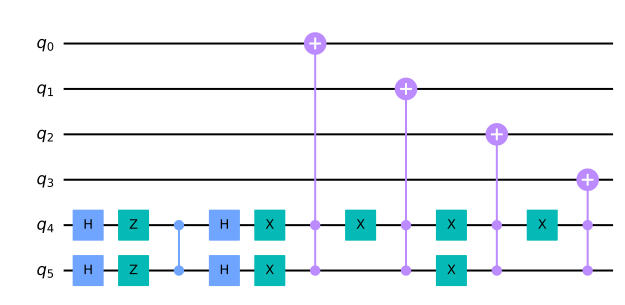

In [4]:
# Shift operator function for 4d-hypercube
def shift_operator(circuit):
    for i in range(0,4):
        circuit.x(4)
        if i%2==0:
            circuit.x(5)
        circuit.ccx(4,5,i)

shift_operator(one_step_circuit)

one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw() 

## 4. 量子ウォークによる探索アルゴリズム <a name="qwalkalgo"></a>
次にグラフ上にマークした要素を見つける量子ウォークによる探索アルゴリズムを実装します。はじめにアルゴリズムを紹介し、その後で実装します。量子ウォークによる探索アルゴリズムは、量子ウォークを用いて、グラフ上にマークした要素を見つける問題を解きます。つまり、ある頂点集合 $|M|$ をマークして、グラフ上の任意の頂点から始め、マークした複数の頂点を見つけるまで移動します。量子ウォークによる探索では基底として、現在の頂点と直前の頂点に対応する二つのレジスタを必要とします。つまりグラフの辺に対応します。遷移行列 $P$ による古典マルコフ連鎖を基にして、$\mathcal{H}$ 上のユニタリ演算子 $W(P)$ により量子ウォークを記述します。また、頂点 $x$ に隣接する頂点の一様な重ね合わせ状態として $\ket{p_x} = \sum_y \sqrt{P_{xy}}\ket{y}$ を定義します。$\ket{x}\ket{y}$ を一つの基底とします。もし $x$ がマークした頂点の場合、基底 $\ket{x}\ket{y}$ を ''good'' と定義します。それ以外を ''bad'' とします。そして、''good'' と ''bad'' 状態は: 

\begin{equation}
    \ket{G} = \frac{1}{\sqrt{|M|}} \sum_{x \in M} \ket{x} \ket{p_x}, \;
    \ket{B} = \frac{1}{\sqrt{N-|M|}} \sum_{x \notin M} \ket{x} \ket{p_x},
\end{equation}

これらは good および bad の基底の重ね合わせ状態です。次に、$\epsilon = |M|/N$ と $\theta = \arcsin(\sqrt{\epsilon})$ を定義します。


まとめると、アルゴリズムは以下の三つのステップからなります:


1. 初期状態として全ての辺の一様な重ね合わせ状態を準備 $\ket{U} = \frac{1}{\sqrt{N}} \sum_{x} \ket{x} \ket{p_x} = \sin{\theta} \ket{G} + \cos{\theta} \ket{B}$
2. $O(1/\sqrt{\epsilon})$ 回繰り返し:
    
    (a) $\ket{B}$ での反射
    
    (b) $\ket{U}$ での反射

3. 計算基底での測定を実施


ステップ $1$ は、アダマールゲートと、$x$ が一つ目のレジスタと等しい時にだけ位相をシフトする位相オラクルを用いて反射を行うことで簡単に実装できます。


ステップ 2(b) は以下の写像を行うユニタリ変換 $R(P)$ を探すことと等価です:
\begin{align}
\label{eq:mapping_1}
    \ket{U} &\mapsto \ket{U}, \: \text{と} \\
    \ket{\psi} &\mapsto -\ket{\psi}, \: \forall \ket{\psi} \text{$\ket{U}$ に直交する $W(P)$ の固有ベクトルに含まれる場合}
\label{eq:mapping_2}
\end{align}

この演算子を探すために、$W(P)$ の位相推定を行います。上記で $W(P)$ をランダムウォークの発展演算子として定義しました。2.1 章で見たように、これはユニタリ演算子です。従って、$W(P)$ の固有値のノルムは $1$ となります。そこで、$W(P)$ の固有値を $e^{\pm 2i\theta_j}$ と書き直します。ユニタリ演算子 $W(P)$ は固有値が $1$ の固有ベクトル $\ket{U}$ を持ちます。これは、$\theta_1=0$ により得られます。$R(P)$ は補助量子ビットを加えて $O(1/\sqrt{\delta})$ の精度で位相推定を行うことで $\ket{U}$ を見つけます、ここで、$\delta$ は $P$ のスペクトルギャップです。これを行うには、$W(P)$ を $O(1/\sqrt{\delta})$ 回作用する必要があります。$\ket{w}$ を $W(P)$ の固有ベクトルで、固有値 $e^{\pm 2i\theta_j}$ を持つとしましょう。 $\tilde{\theta_j}$ を位相推定による $\theta_j$ のもっとも良い推定値と仮定します。ステップ 2(b) の $\ket{w}$ の写像を与える演算子 $R(P)$ は文献[4]で与えられています。

\begin{equation}
    \ket{w} \ket{0} \mapsto \ket{w} \ket{\tilde{\theta_j}} \mapsto (-1)^{|\tilde{\theta_j} \neq 0|} \ket{w} \ket{\tilde{\theta_j}} \mapsto (-1)^{|\tilde{\theta_j} \neq 0|} \ket{w} \ket{0}
\end{equation}


## 5.例: 4次元超立方体上の量子ウォークによる探索 <a name="qiskiti"></a>


量子ウォークによる探索アルゴリズムは $O(1/\sqrt{\epsilon})$ ステップでマークされた頂点の集合を探すことができます、ここで $\epsilon =  |M|/N$、$M$ はマークした頂点数、$N$ は全ての頂点数です。このアルゴリズムは元はセゲディ量子ウォークを使い、量子状態を表現する二つの頂点レジスタを用いました。しかしグローバーコインを用いるコイン量子ウォークはセゲディ量子ウォークと等価で、コイン量子ウォークは一般的に簡素に実装できるため、コイン量子ウォークによる実装を選びます。3 章で紹介した4次元超立方体を用います。

まとめると、以下のようにアルゴリズムを実装します。ステップ 1 を行うには、頂点レジスタの全ての量子ビットにアダマールゲートを作用させて全ての辺の一様な重ね合わせ状態を作ります。ステップ 2(a) では、位相オラクルを実装します。ステップ 2(b) は、超立方体の量子ウォークの一ステップ分の位相推定と、$\theta \neq 0$ となるすべての量子状態のマークを行います。これを補助量子ビットの回転により行います。最後のステップは、位相推定の逆演算を行います。位相推定に必要な量子ビットは $\theta$ の精度に依存します。

以下、4次元超立方体の量子ウォークによる探索アルゴリズムを実装します。

このアルゴリズムでは、一ステップ分のゲートに対して以前実装した反転を必要とします。これはビルトイン関数 inverse() で行えます。

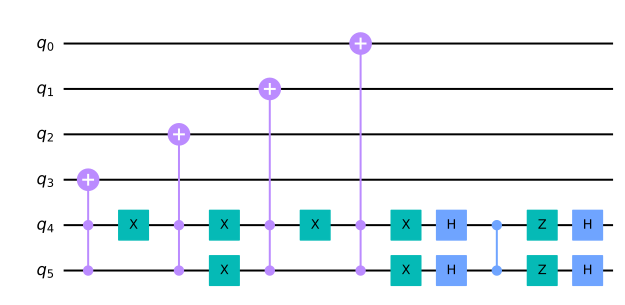

In [5]:
one_step_circuit.inverse().draw() 

一ステップ分のゲートの反転は後で位相推定の逆計算に使用します。3 章で実装した一ステップ分のゲートとその反転のゲートは、制御ゲートを必要とします。これらを後に制御量子ビットに応じて使用します。

In [6]:
# Make controlled gates
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

制御された一ステップ分のゲートと、制御された一ステップ分の反転ゲートは位相推定に用いられます。位相推定には量子フーリエ変換も用います。Qiskit では量子フーリエ変換を実装した QFT 関数があります。位相推定には逆量子フーリエ変換を用いますが、位相推定の逆計算にも通常の QFT を使用します。

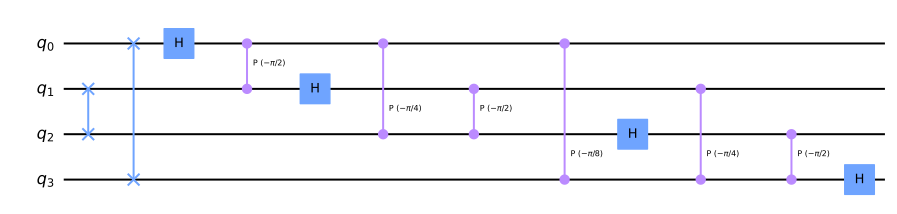

In [7]:
inv_qft_gate = QFT(4, inverse=True).to_instruction()  
qft_gate = QFT(4, inverse=False).to_instruction()

QFT(4, inverse=True).decompose().draw("mpl")

位相推定を実装する前に、1011 と 1111 をマークする位相オラクルを実装します。その後、回路を作成します。これはアルゴリズムのステップ 2(a) です。

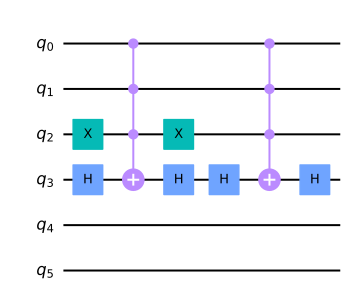

In [8]:
phase_circuit =  QuantumCircuit(6, name=' phase oracle ')
# Mark 1011
phase_circuit.x(2)
phase_circuit.h(3)
phase_circuit.mct([0,1,2], 3)
phase_circuit.h(3)
phase_circuit.x(2)
# Mark 1111
phase_circuit.h(3)
phase_circuit.mct([0,1,2],3)
phase_circuit.h(3)
phase_oracle_gate = phase_circuit.to_instruction()
# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(11, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
phase_circuit.draw() 

他の量子ビットがゼロでない場合に補助量子ビットを回転するゲートを実装します。このゲートは位相推定で用いられ、$\theta \neq 0$ の時に補助量子ビットを回転します。

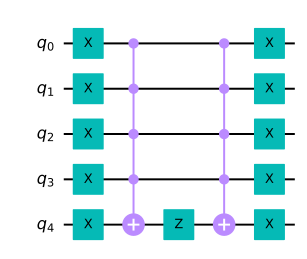

In [9]:
# Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(5, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3,4])
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.z(4)
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.x([0,1,2,3,4])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw()

次にアルゴリズムのステップ 2(b) を実装します。このステップは、量子ウォーク一ステップ分の位相推定と、$\theta \neq 0$ の時の補助量子ビットの回転操作を含みます。このために、直前に作成した mark_auxiliary_gate を用います。その後、位相推定の逆演算を行います。

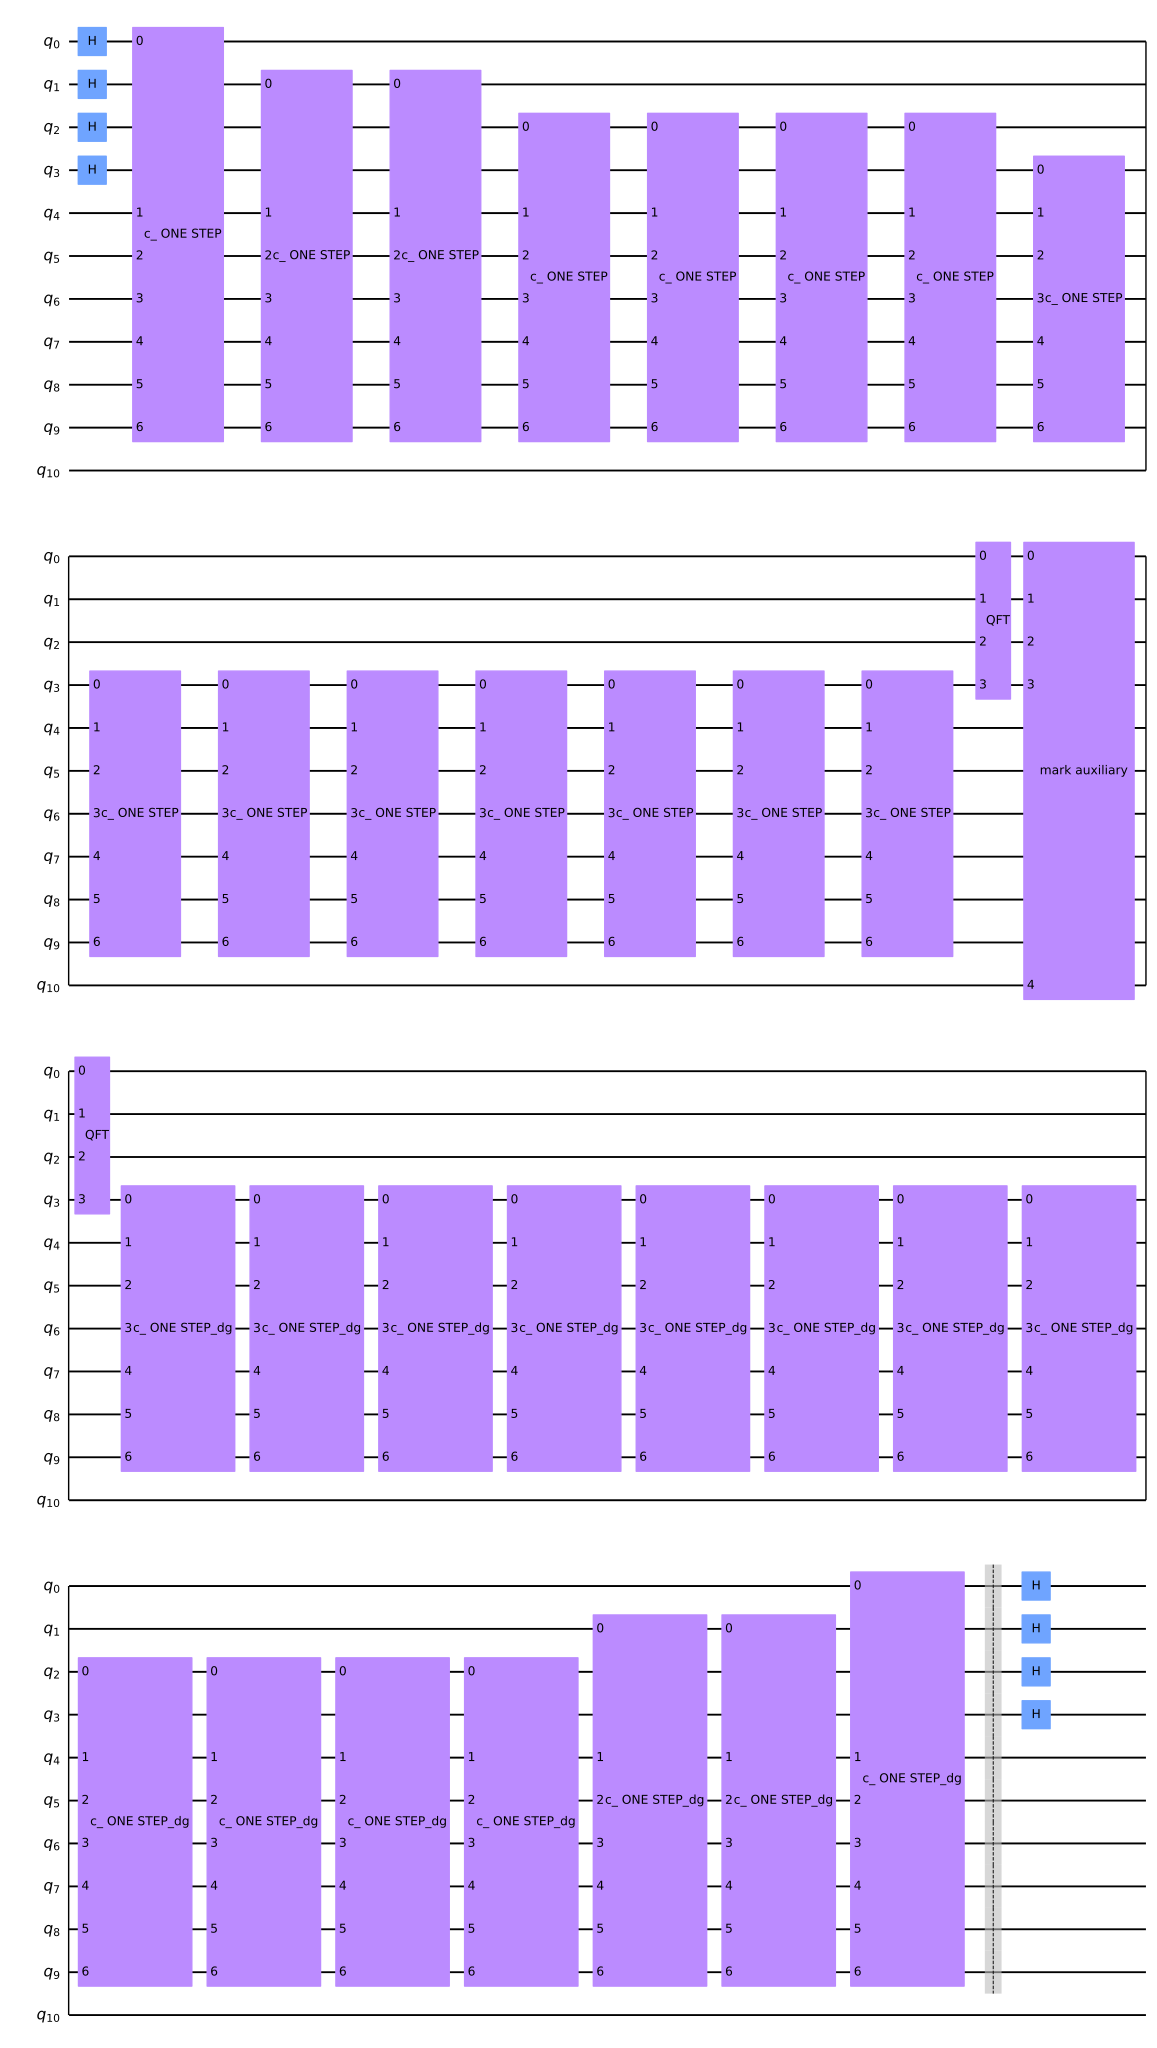

In [11]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(11, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i,4,5,6,7,8,9])

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,3,10])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])   

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i,4,5,6,7,8,9])
phase_estimation_circuit.barrier(range(0,10))
phase_estimation_circuit.h([0,1,2,3])

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw() 

ここで、これまで作成したゲートを用いて、量子ウォークによる探索アルゴリズムの全体を実装します。最初は、ステップ 1 の頂点とコインの量子ビットにアダマールゲートを作用させます。その後、ステップ 2(a) と 2(b) の位相オラクルゲートと位相推定ゲートを繰り返し作用させます。4 章でアルゴリズムを説明したように、$O(1/\sqrt{\epsilon})$ 回の繰り返しが必要です。最後に頂点量子ビットを測定します。

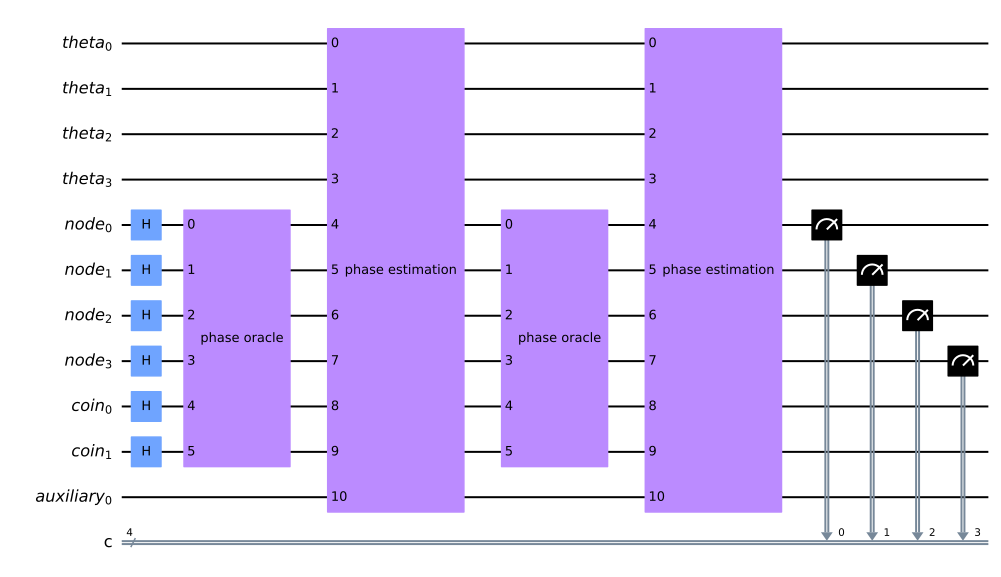

In [12]:
# Implementation of the full quantum walk search algorithm
theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(4, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
# Apply Hadamard gates to the qubits that represent the nodes and the coin
circuit.h([4,5,6,7,8,9])
iterations = 2

for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9,10])

circuit.measure(node_q[0], creg_c2[0])
circuit.measure(node_q[1], creg_c2[1])
circuit.measure(node_q[2], creg_c2[2])
circuit.measure(node_q[3], creg_c2[3])
circuit.draw()

最後に、この実装を qasm シミュレータで実行します。マークした状態へとはっきりと集まっていることが分かります。

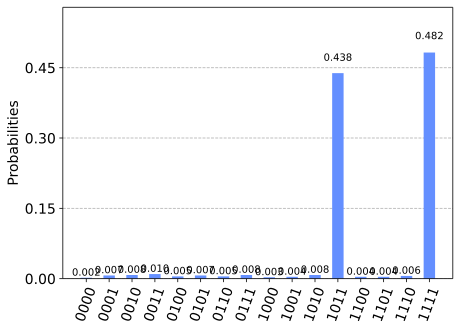

In [13]:
backend = Aer.get_backend('qasm_simulator') 
job = execute( circuit, backend, shots=1024 ) 
hist = job.result().get_counts() 
plot_histogram( hist )

## 6. 参考文献 <a id='references'></a>

1. Renato Portugal. Quantum Walks and Search Algorithms. New York, NY: Springer New York, 2013
2. Markus G. Kuhn.Some Introductory Notes on Quantum Computing. Apr. 2000
3. Thomas G. Wong. “Equivalence of Szegedy’s and coined quantum walks”. In: Quantum InformationProcessing 16.9 (July 2017). ISSN: 1573-1332. DOI:10.1007/s11128-017-1667-y. URL:http://dx.doi.org/10.1007/s11128-017-1667-y.37
4. Ronald de Wolf. Quantum Computing: Lecture Notes. 2021. arXiv:1907.09415 [quant-ph]

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
